# K-Means and Principal Component Analysis

Hey there, hi there, ho there, dear reader! Today we venture into the world of unsupervised learning in Andrew Ng's machine learning class on Coursera ((https://www.coursera.org/learn/machine-learning). Unsupervised learning is when our data is not explicitly labeled, and we ask the algorithm to learn something meaningful on its own without labels. First, we will implement K-Means, which is a clustering algorithm, from scratch and then in scikit learn. We will see that not only can we use K-Means for identifying groupings in data, but we can also use it for other practical applications, like image compression. Next, we will implement principal component analysis (PCA), which can be used to lower the dimensionality of our data by maintaining as much variance or variability as possible while also removing part of the data. PCA is useful for data visualization and analysis when the data dimensionality is too great to be visualized in two or three dimensions and can also be used to improve model speed when the data is just too big. It too can be used for image compression, as we will soon see. Let's get started!

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.io import loadmat
%matplotlib inline
#set default figure size
mpl.rcParams['figure.figsize'] = (12, 8)

In [2]:
data1 = loadmat('data/ex7data2.mat')

In [3]:
X1 = data1['X']
print('X1: {0}'.format(X1.shape))

X1: (300, 2)


## K-Means

Okay, so the algorithm for K-Means is described as follows:

_% Initialize centroids_
_centroids = kMeansInitCentroids(X, K);_

_for iter = 1:iterations_
        
_% Cluster assignment step: Assign each data point to the closest centroid. idx(i) corresponds to cˆ(i), the index of the           centroid assigned to example i_

    idx = findClosestCentroids(X, centroids);
_% Move centroid step: Compute means based on centroid assignments_

    centroids = computeMeans(X, idx, K);

_end_

So, this for loop does two things: (1) Assigns each training example $x^{(i)}$ to its closest centroid and (2) Recomputes the mean of each centroid using the points assigned to it. K-Means always converges to some final set of means for the centroids, but it is not always the case that solution is ideal because the solutions depends on the initial setting of the centroids, as we will soon see. As a result, we usually run K-Means a couple times with different random initializations. We choose the best solution based on a cost function also called distortion.  Also, if you're curious, K refers to the number of clusters we're telling the algorithm to find.


Before all that, though, let's code up a function to take a look at the data and centroids that Andrew Ng chose arbitrarily. In this function, we will decompose our data matrix into the number centroids we're provided when there are no indices available. An index will be what tells our algorithm the data points associated with each centroid. If we do have index, we can then just plot the data based on which centroid each point is assigned to by the algorithm.

In [6]:
def plotData(X, centroids, idxs = None):

      
    colors = ['blue','red', 'cyan','darkorange', 'salmon', 'magenta']
    
    assert(X[0].shape == centroids[0][0].shape)
    assert(centroids[-1].shape[0] <= len(colors))

    #No indices
    if idxs is not None:
        assert(idxs.shape[0] == X.shape[0])
        X_ = []
        for i in np.arange(centroids[0].shape[0]):
            X_.append(np.array([X[j] for j in np.arange(X.shape[0]) if idxs[j] == i]))
    else:
        X_ = [X]
        
    fig = plt.figure(figsize = (12, 8))
    for i in np.arange(len(X_)):
        newX = X_[i]
        plt.plot(newX[:, 0], newX[:, 1], 'o', color = colors[i], label = 'Cluster {0}'.format(i + 1))
    plt.xlabel('x1', fontsize = 15)
    plt.ylabel('x2', fontsize = 15)
    plt.title('Data and Clusters', fontsize = 18)

    
    x_ = [] ; y_ = []
    for centroid in centroids:
        x_.append(centroid[:, 0])
        y_.append(centroid[:, 1])
    
    for i in np.arange(len(x_[0])):
        plt.plot(x_, y_, '*--', markersize = 15) # *-- denotes centroids and their movement

    plt.legend()

Okay, with that done we can use K and an initial centroid and take our function for a spin.

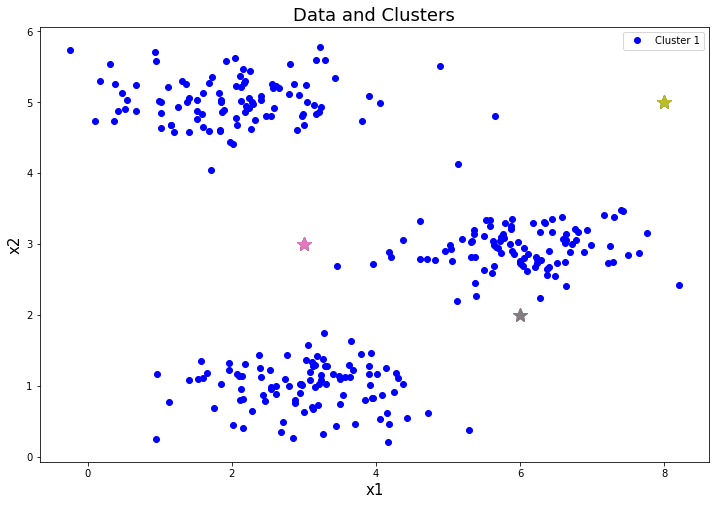

In [7]:
K = 3
initial_centroids = np.array([[3,3], [6,2], [8,5]])
plotData(X1, [initial_centroids])

### Finding closest centroids

So now we need to assign each training example to the closest centroid based on which centroid the example is closest to. Formally, we want to find:

$ c^{(i)} := j $ that minimizes $ ||x^{(i)} - \mu_j||^2 $

Here, $c^{(i)}$ is the index of the centroid closest to $x^{(i)}$, and $\mu_j$ is the position of a centroid. Let's code it up.

In [8]:
def findClosestCentroids(X, centroids):  
    m = X.shape[0]
    k = centroids.shape[0]
    idx = np.zeros(m)
    for i in np.arange(m):
        min_distance = 1000000
        for j in np.arange(k):
            distance = np.sum(np.square(X[i, :] - centroids[j, :]))
            if distance < min_distance:
                min_distance = distance
                idx[i] = j
            
    return idx

To make sure it works, Professor Ng says the first 3 entries should be 1, 3, and 2, which we get if we account for python's indexing from 0.

In [9]:
index = findClosestCentroids(X1, initial_centroids)
for i in index[0:3]:
    print(int(i) + 1)

1
3
2


Let's see what our clusters look like in all their glory!

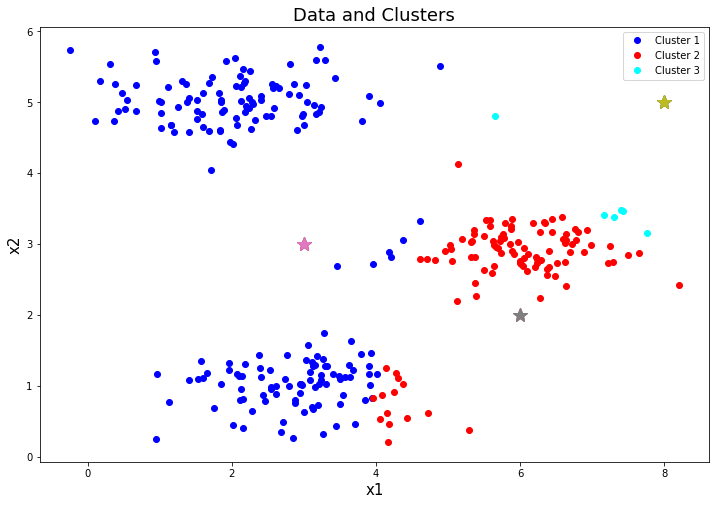

In [10]:
plotData(X1, [initial_centroids], index)

That's part one of K-Means done, although as you can see above, our clusters need some work. Time for part 2!

### Computing Centroid Means

To compute each centroid k we set

$$ \mu_k:= \frac{1}{|C_k|} \sum_{i\in C_k}x^{(i)}$$

where $C_k$ is the set of examples assigned to centroid k. All this equation means is updating $\mu_k$ (the mean of some cluster) by adding the data points assigned to its centroid together and then dividing by the number of data points, that is, the mean. 

In [11]:
def computeCentroids(X, idxs):
    X_ = []
    for i in np.arange(len(np.unique(idxs))):
        X_.append(np.array([X[j] for j in np.arange(X.shape[0]) if idxs[j] == i]))
        centroids = np.array([np.mean(i, axis = 0) for i in X_])
    
    return centroids

In [16]:
print("Centroid Means: \n{0}".format(computeCentroids(X1, index)))

Centroid Means: 
[[2.42830111 3.15792418]
 [5.81350331 2.63365645]
 [7.11938687 3.6166844 ]]


Okay, now we can actually implement K-Means by putting our two functions together. We can also save our centroids on each iteration, 10 in this case, to see how the centroids move.

In [17]:
def runKMeans(X, initial_centroids, iters):
    history = []
    centroids = initial_centroids
    for i in np.arange(iters):
        history.append(centroids)
        idx = findClosestCentroids(X, centroids)
        centroids = computeCentroids(X, idx)
        
    return history, idx

In [18]:
history, indices = runKMeans(X1, initial_centroids, 10)

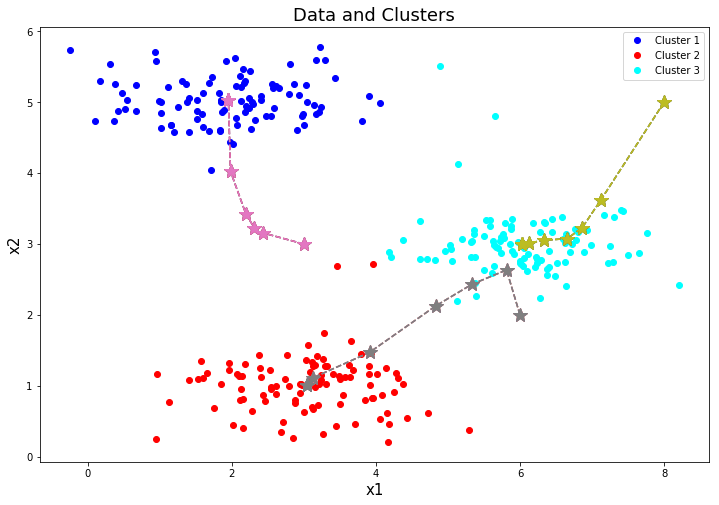

In [19]:
plotData(X1, history, indices)

Pretty cool! Now for the final part which is random intialization, the psuedocode for which is

_% Initialize centroids to be random examples_
        
_% Randomly reorder the indices of examples._

    randidx = randperm(size(X, 1));

_% Take the first K examples as centroids_

    centroids = X(randidx(1:K), :);

That's octave and matlab code, which is pretty simple to translate into python.

In [20]:
def randomInitialization(X, K):
    m, n = X.shape
    centroids = np.zeros((K, n))
    randidx = np.random.randint(0, m, K)
    
    for i in np.arange(K):
        centroids[i, :] = X[randidx[i], :]
        
    return centroids

In [21]:
print("Random Centroids: \n{0}".format(randomInitialization(X1, 3)))

Random Centroids: 
[[5.64034678 2.69385282]
 [5.05274526 2.75692163]
 [7.42892098 3.4667949 ]]


Now let's run our K-Means code 3 different times to see how the clusters can change and not necessarily yield ideal results every time.

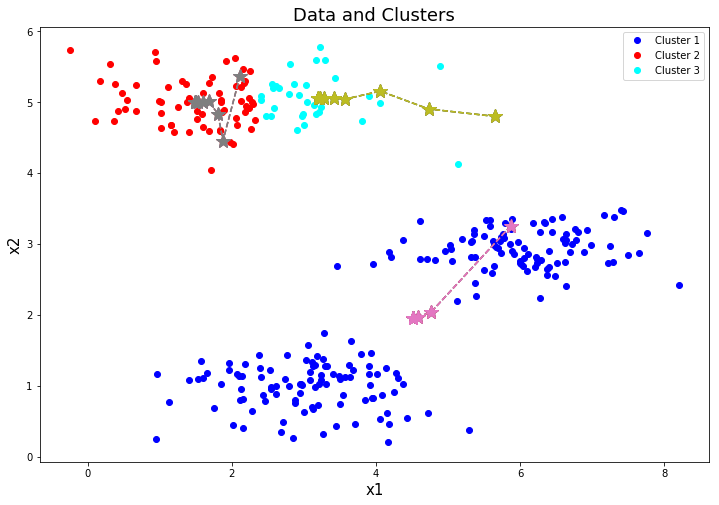

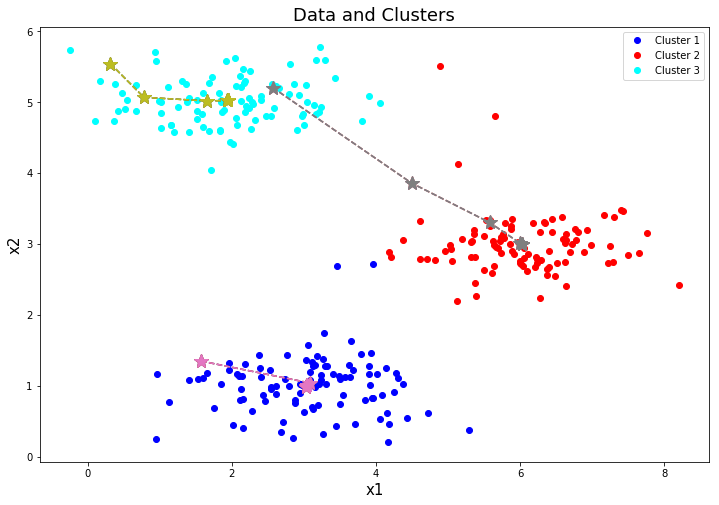

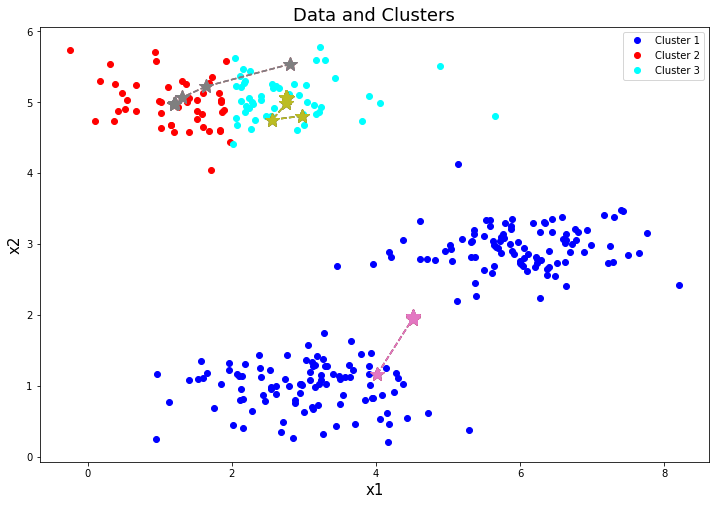

In [24]:
for i in np.arange(3):
    history, indices = runKMeans(X1, randomInitialization(X1, 3), 10)
    plotData(X1, history, indices)

As we can see above, the second iteration was pretty good and yielded pretty decent clusters. However, the first and third iterations are a bit of a mess. 

### KMeans with Scikit Learn
There's no need to code up K-Means from scratch everytime you've got some data to cluster, though! Scikit learn is more than happy to help!

In [25]:
from sklearn.cluster import KMeans
km1 = KMeans(3)
km1.fit(X1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

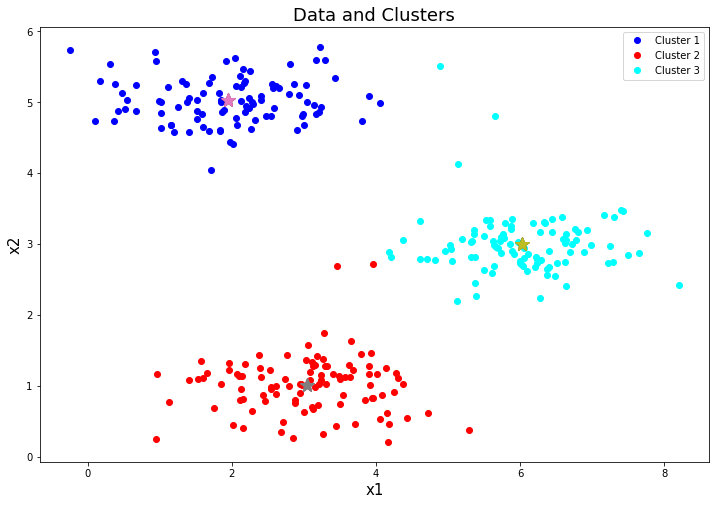

In [26]:
plotData(X1, [km1.cluster_centers_], km1.labels_)

It's always encouraging when code from scratch and professional code yield similar, if not exactly the same results, don't you think?

## Image Compression with K-Means

Now it's time to do something a bit less abstract.

Professor Ng says: 

In this exercise, you will apply K-means to image compression. In a straightforward 24-bit color representation of an image, each pixel is represented as three 8-bit unsigned integers (ranging from 0 to 255) that specify
the red, green and blue intensity values. This encoding is often refered to as the RGB encoding. Our image contains thousands of colors, and in this part of the exercise, you will reduce the number of colors to 16 colors. By making this reduction, it is possible to represent (compress) the photo in an efficient way. Specifically, you only need to store the RGB values of the 16 selected colors, and for each pixel in the image you now need to only store the index of the color at that location (where only 4 bits are necessary to represent 16 possibilities). In this exercise, you will use the K-means algorithm to select the 16 colors that will be used to represent the compressed image. Concretely, you will treat every pixel in the original image as a data example and use the K-means algorithm to find the 16 colors that best group (cluster) the pixels in the 3-dimensional RGB space. Once you have computed the cluster centroids on the image, you will then use the 16 colors to replace the pixels in the original image.

Cool! Let's have a look-see.

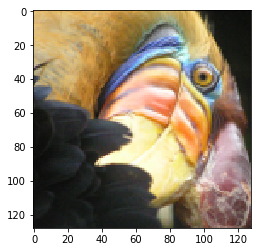

In [27]:
import matplotlib.image as mpimg
pic = 'data/bird_small.png'
pic = mpimg.imread(pic)
plt.imshow(pic)

In [28]:
pic_data = loadmat('data/bird_small.mat')
pic_data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue Jun  5 04:06:24 2012',
 '__version__': '1.0',
 '__globals__': [],
 'A': array([[[219, 180, 103],
         [230, 185, 116],
         [226, 186, 110],
         ...,
         [ 14,  15,  13],
         [ 13,  15,  12],
         [ 12,  14,  12]],
 
        [[230, 193, 119],
         [224, 192, 120],
         [226, 192, 124],
         ...,
         [ 16,  16,  13],
         [ 14,  15,  10],
         [ 11,  14,   9]],
 
        [[228, 191, 123],
         [228, 191, 121],
         [220, 185, 118],
         ...,
         [ 14,  16,  13],
         [ 13,  13,  11],
         [ 11,  15,  10]],
 
        ...,
 
        [[ 15,  18,  16],
         [ 18,  21,  18],
         [ 18,  19,  16],
         ...,
         [ 81,  45,  45],
         [ 70,  43,  35],
         [ 72,  51,  43]],
 
        [[ 16,  17,  17],
         [ 17,  18,  19],
         [ 20,  19,  20],
         ...,
         [ 80,  38,  40],
         [ 68,  39,  40],
     

In [29]:
A = pic_data['A']
A.shape

(128, 128, 3)

In [30]:
A = A / 255
# 3-channel array --> 1 channel matrix
X2 = np.reshape(A, (A.shape[0] * A.shape[1], A.shape[2]))
X2.shape

(16384, 3)

Now that we've set up our $X2$ matrix, we just to run our algorithm again.

In [31]:
initial_centroids = randomInitialization(X2, 16)

In [32]:
history, indices = runKMeans(X2, initial_centroids, 10)

In [33]:
#get the final iteration and cluster positions
hist = history[-1]
indices = findClosestCentroids(X2, hist)

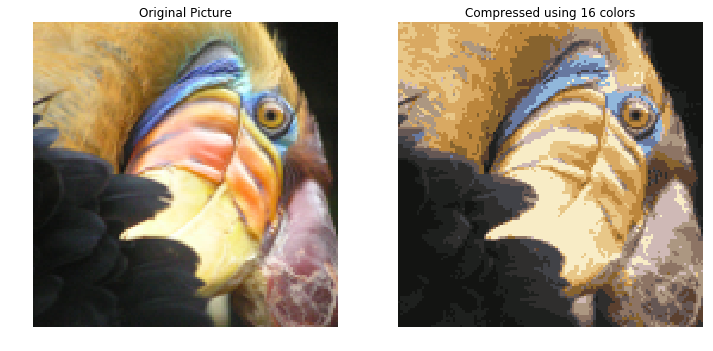

In [34]:
image = np.zeros((indices.shape[0], 3))
for i in np.arange(image.shape[0]):
    image[i] = hist[indices[i].astype(int)]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))   
ax1.imshow(pic)
ax1.set_title("Original Picture")
ax2.imshow(image.reshape(A.shape))
ax2.set_title("Compressed using 16 colors")

for ax in fig.axes:
    ax.axis('off')

I think that is just so cool! Of course, again, scikit learn could help us out here as well. In fact, why don't we compare our result to scikit learn's?

### K-Means Image Compression with Scikit Learn

In [35]:
km2 = KMeans(16)
km2.fit(X2)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=16, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

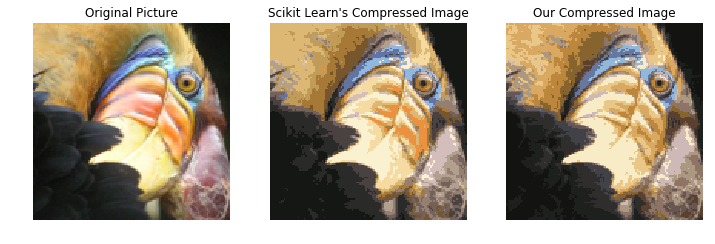

In [36]:
sci_image = km2.cluster_centers_[km2.labels_].reshape(A.shape)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 8))   
ax1.imshow(pic)
ax1.set_title("Original Picture")
ax2.imshow(sci_image)
ax2.set_title("Scikit Learn's Compressed Image")
ax3.imshow(image.reshape(A.shape))
ax3.set_title("Our Compressed Image")

for ax in fig.axes:
    ax.axis('off')

Not a big difference, I'd say, which is pretty cool. Anyway, that's a wrap on K-Means. Now, let's reduce some dimensionality with PCA!

## Principal Component Analysis

In ths first part of this exercise, we're going to play around with 2D toy data that has a large degree of variation in one direction with very little in the other. While going from 2D to 1D is a pretty arbitrary change, it's a good way to get intuition about what the algorithm is doing, as we can only use plots when we're dealing with a few dimensions. 


Let's load up the data and draw a quick scatterplot.

In [38]:
data2 = loadmat('data/ex7data1.mat')

In [39]:
X3 = data2['X']
print('X3: {0}'.format(X3.shape))

X3: (50, 2)


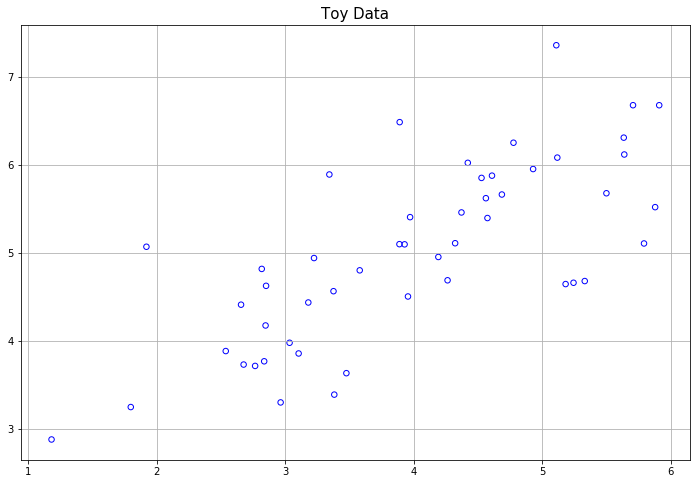

In [40]:
fig, ax = plt.subplots(figsize = (12, 8))  
ax.scatter(X3[:, 0], X3[:, 1],  s = 30, facecolors = 'none', edgecolors = 'b')
plt.title("Toy Data", fontsize = 15)
plt.grid(True)

PCA time! Now PCA consists of three computational steps:

__(1) Normalize Features:__ Compute the mean --> subtract the mean from original data --> compute the standard deviation --> divide new data by the standard deviation. Formally:
$$ X_{norm} = \frac{(X - \mu)}{\sigma} $$

__(2) Compute Covariance Matrix $\Sigma$:__ After normalization, compute $\Sigma$:

$$ \Sigma = \frac{1}{m}X^TX $$

where $X$ is our normalized data matrix, and $m$ is the number of data points.

__(3) Singular Value Decomposition:__ SVD computes the eigenvectors $U_1, U_2, ..., U_n$, using the covariance matrix $\Sigma$. The eigenvectors correspond to the principal components of variation in the data.

Numpy's linear algebra functionality can do this for us lickity split and will output $U, S, V$, where $U$ is our matrix of eigenvectors and $S$ is the diagonal matrix. We won't make use of $V$, sadly.

Simple enough, let's code it up. We'll return all the values we compute for graphing purposes.

In [42]:
def doPca(X):
    mean = np.mean(X, axis = 0)
    X_norm = X - mean
    std  = np.std(X_norm, axis = 0)
    X_norm = X_norm / std
    cov = X_norm.T.dot(X_norm) / X_norm.shape[0]
    U, S, V = np.linalg.svd(cov, full_matrices = True, compute_uv = True)
    
    return mean, std, X_norm, U, S, V

In [44]:
X3_mean, X3_std, X3_norm, X3_U, X3_S, X3_V = doPca(X3)
print("U:\n {0} ".format(X3_U), "\n")
print("S: \n {0}".format(X3_S), "\n")
print("V: \n {0}".format(X3_V), "\n")

U:
 [[-0.70710678 -0.70710678]
 [-0.70710678  0.70710678]]  

S: 
 [1.73553038 0.26446962] 

V: 
 [[-0.70710678 -0.70710678]
 [-0.70710678  0.70710678]] 



These are values Professor Ng told us to expect, so I guess we're on the right track.

Let's draw a plot to see the principal components. In order to draw the principal components, we need to start at the mean of the data and then add on our $x$ and $y$ components of the $S$ and $U$ matrices.

In [47]:
def plotPca(X, mean, S, U, X_rec, X_normed = False):
    
    plt.figure(figsize = (12, 8))
    plot = plt.scatter(X[:, 0], X[:, 1], s = 30, facecolors='none', edgecolors = 'b', label = "2-Dimensional Data")
    plt.grid(True)
       
    if X_normed == False:
        
        plt.title("Toy Data with Eigenvectors from PCA", fontsize = 20)
        plt.xlabel('x1', fontsize = 15)
        plt.ylabel('x2', fontsize = 15)
        plt.plot([mean[0], mean[0] + 1.5 * S[0] * U[0, 0]], [mean[1], mean[1] +  1.5 * S[0] * U[0, 1]],
            color = 'black', linewidth = 2, label = 'First Principal Component')
        plt.plot([mean[0], mean[0] + 1.5 * S[1] * U[1, 0]], [mean[1], mean[1] + 2 * S[1] * U[1, 1]],
            color = 'green', linewidth = 2, label= 'Second Principal Component')
        plt.legend()
        
    else:
        
        plot = plt.scatter(X_rec[:, 0], X_rec[:, 1], s = 30, facecolors = 'none', edgecolors = 'r', 
                           label = 'Data Projected to Lower Dimension')
        plt.title("Toy Data: Dimensionality Reduced", fontsize = 20)
        plt.xlabel('Normalized x1', fontsize = 15)
        plt.ylabel('Normalized x2', fontsize = 15)
        plt.legend()
              
        for i in np.arange(X.shape[0]):
            plt.plot([X[i, 0], X_rec[i, 0]], [X[i, 1], X_rec[i, 1]], 'k--')

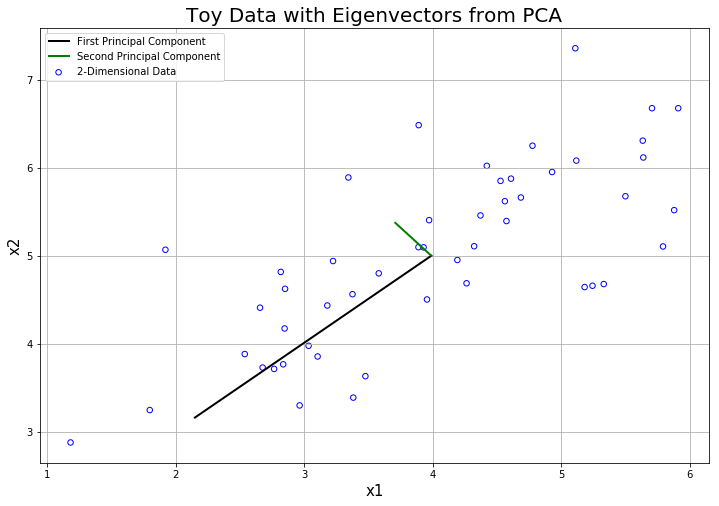

In [48]:
plotPca(X3, X3_mean, X3_S, X3_U, X3)

Looks good! As you can see, the majority of our variation forms a line increasing from the lower left to the upper right. On the other hand, our second principal component shows our secondary variation coming from the opposite direction. 

Now we can project the data to a lower dimension (2D to 1D), that is, $x^{(i)} \rightarrow z^{(i)}$. We can do this by simply extracting out the number of eigenvectors in $U$ that we want to reduce to, in this case 1, so we just take the first vector out of $U$, which I will call $U_1$. Then we compute the vector $z$ by dotting $U_1$ with our $X_{norm}$ matrix. Should we want to recover our our original $X$ matrix from the $z$ vector for some reason, we only need to dot $U_1^T$ with the $z$ vector. The resulting matrix is only an approximation, however.

In [50]:
def projectData(X, U, k):  
    U_reduce = U[:, :k]
    z = np.dot(X, U_reduce)
    
    return z


def recoverX(z, U, k):  
    U_reduce = U[:, :k]
    X_rec = np.dot(z, U_reduce.T)
    
    return X_rec

In [51]:
z = projectData(X3_norm, X3_U, 1)
print("z: {0}".format(z.shape))

z: (50, 1)


In [53]:
X_recov = recoverX(z, X3_U, 1)
print("X_recov: {0}".format(X_recov.shape))

X_recov: (50, 2)


Huzzah! Now let's plot the data projection and compare it to the original data. In this case, we need to pass our plotting function our normalized data matrix.

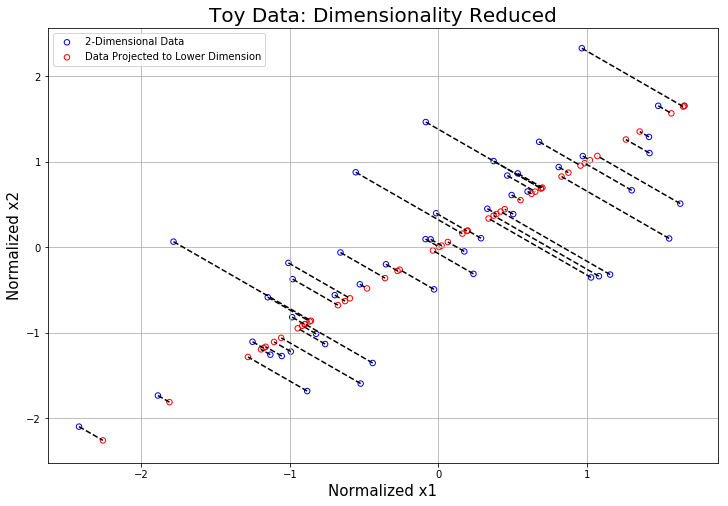

In [54]:
plotPca(X3_norm, X3_mean, X3_S, X3_U, X_recov, X_normed = True)

Above, we can see how each data has moved to its new position in a lower dimension. Pretty cool!

Of course, scikit-learn is happy to help us out in a pinch as well.

### PCA with Scikit Learn

In [55]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
pca_result = pca.fit_transform(X3)

In [56]:
pca

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [58]:
print("pca_result: {0}".format(pca_result.shape)) 
print('Variation per principal component: {0}'.format(pca.explained_variance_ratio_))

pca_result: (50, 2)
Variation per principal component: [0.87062385 0.12937615]


The above ratio is how much of the variance or variability in our data is captured by the two principal components.

Let's see how scikit learn's implementation compares to ours!

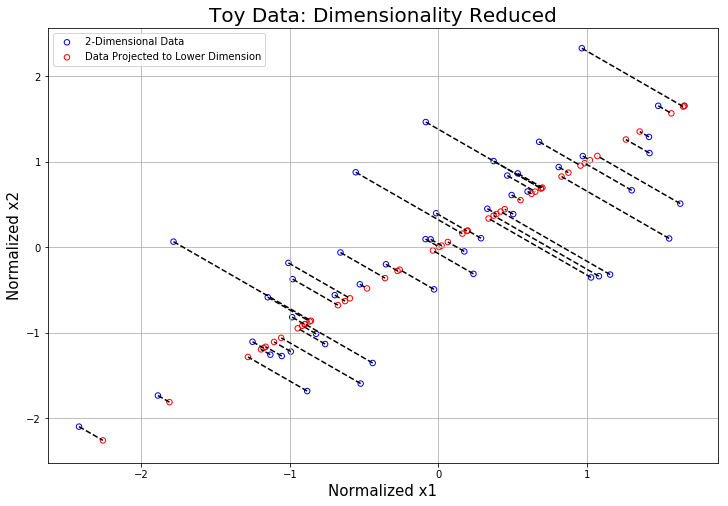

In [59]:
plotPca(X3_norm, pca.mean_, pca.explained_variance_, pca.components_, X_recov, X_normed = True)

Looks the same to me! That's pretty cool! Now, let's make some eigenfaces.

## Face Image Dataset

Professor Ng says:

In this part of the exercise, you will run PCA on face images to see how it can be used in practice for dimension reduction. The dataset ex7faces.mat contains a dataset2 $X$ of face images, each 32 x 32 in grayscale. Each row of $X$ corresponds to one face image (a row vector of length 1024).

Let's load in the data and write a function that builds the picture from the matrix row by row.

In [63]:
faces = loadmat('data/ex7faces.mat')  
X4 = faces['X']  
print('X4: {0}'.format(X4.shape))

X4: (5000, 1024)


In [64]:
import matplotlib.cm as cm
import scipy
def displayPics(X, rows, columns, width, height):
    pic = np.zeros((rows * height, columns * width))
    row = 0;  col = 0
    for i in np.arange(rows * columns):
        if col == columns:
            row += 1
            col = 0
        image = (X[i].reshape(width, height)).T
        pic[height * row : height * row + image.shape[0], width * col : width * col + image.shape[1]] = image
        col += 1
    plt.figure(figsize = (12, 12))
    pics = scipy.misc.toimage(pic)
    plt.imshow(pics, cmap = cm.Greys_r)
    

C:\Users\Theochem\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  


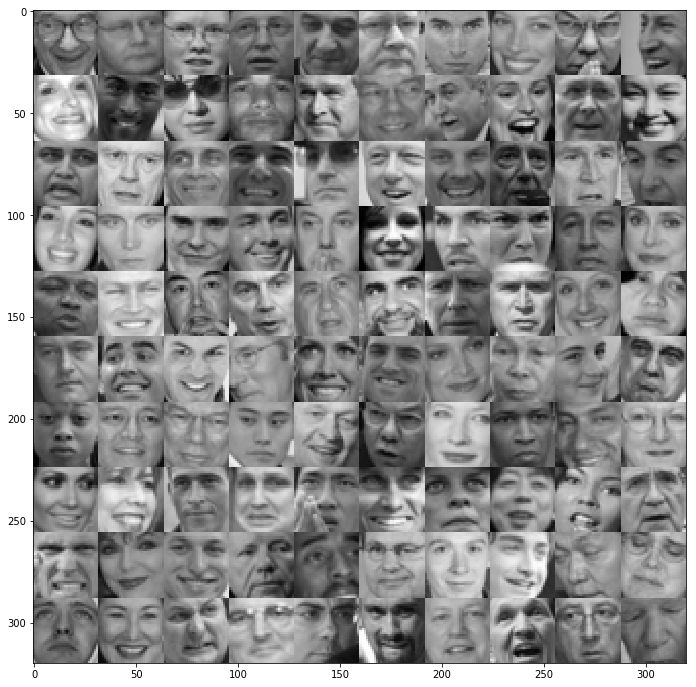

In [65]:
displayPics(X4, 10, 10, 32, 32)

Creepy, huh? Well, we've only just begun. Let's run our PCA implementation and see what happens to our dimensionality reduced faces.

In [67]:
X4_mean, X4_std, X4_norm, X4_U, X4_S, X4_V = doPca(X4)
print("X4_U: {0}".format(X4_U.shape))

X4_U: (1024, 1024)


C:\Users\Theochem\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  


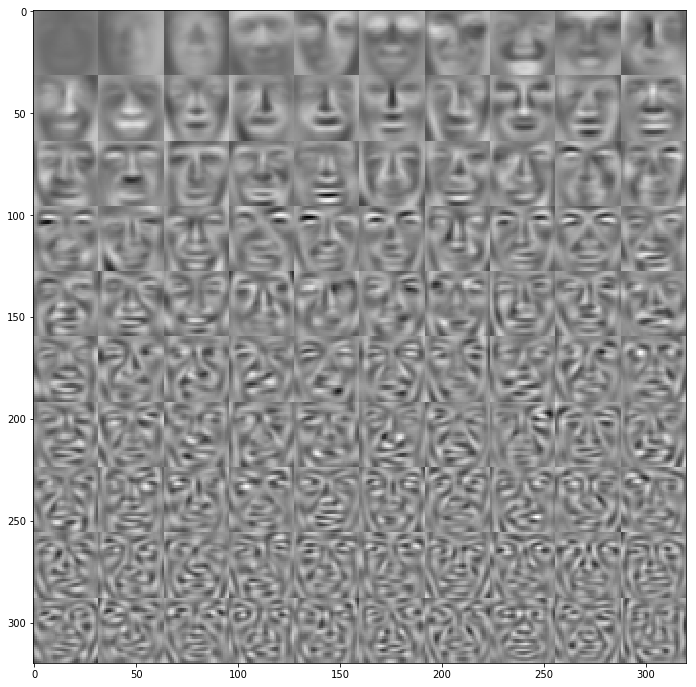

In [70]:
displayPics(X4_U.T, 10, 10, 32, 32)

What have we done? That's the stuff of nightmares right there. We can try to rebuild the faces by projecting to the lower dimension and recovering our $X$ matrix.

In [83]:
z4 = projectData(X4, X4_U, 100)

In [84]:
X4_recov = recoverX(z4, X4_U, 100)
print("X4_recov: {0}".format(X4_recov.shape))

X4_recov: (5000, 1024)


C:\Users\Theochem\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  


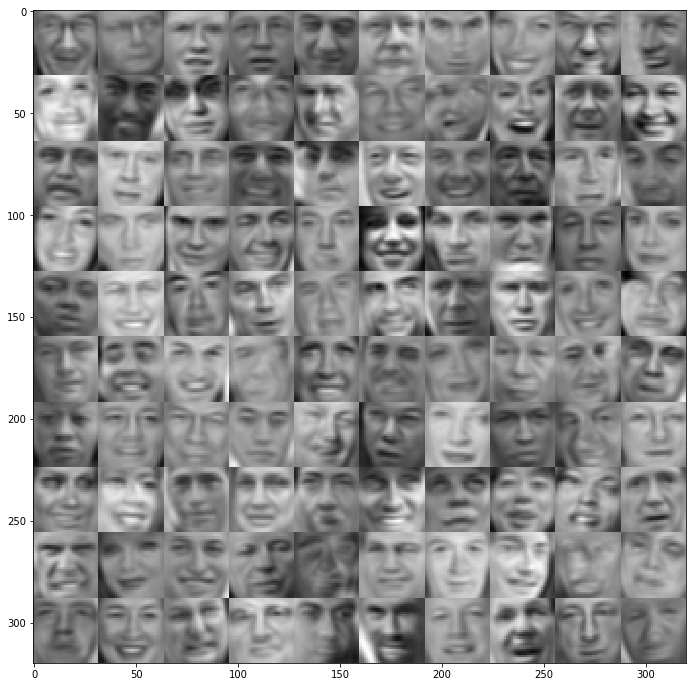

In [85]:
displayPics(X4_recov, 10, 10, 32, 32)

I'm not sure which is worse: the original picture or our PCA approximation. For your information, dear reader, what we have done is projected the original dataset onto the first 100 principal components. What that means is that in the above picture, each face is now respresented by a vector $z^{(i)} \in {\rm I\!R^{100}} $ which is vector of 100 values. Clearly, we need slightly more.

Again, scikit learn happy to oblige with this task as well.

### PCA on Face Data with Scikit Learn

In [86]:
pca2 = PCA(100)
pca_result2 = pca2.fit_transform(X4)
print("pca_result2: {0}".format(pca_result2.shape))

pca_result2: (5000, 100)


In [87]:
approx = pca2.inverse_transform(pca_result2)
approx.shape == X4_recov.shape

True

C:\Users\Theochem\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  


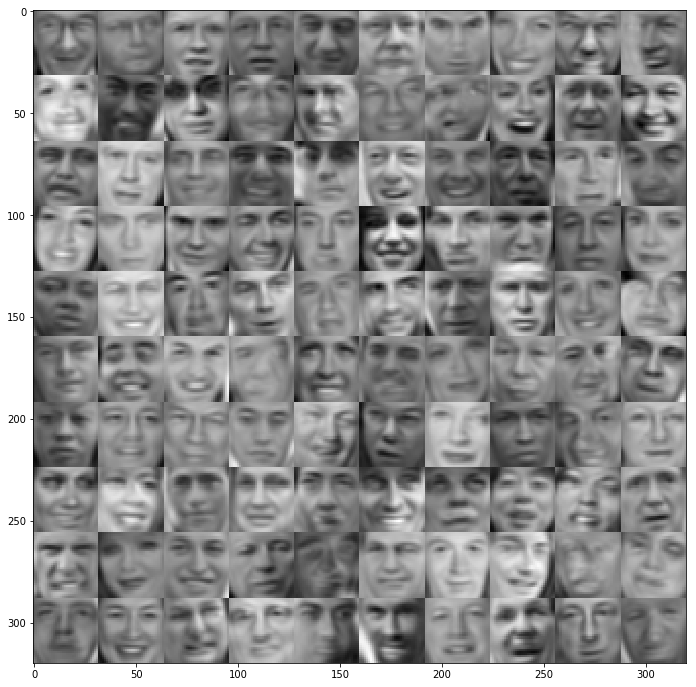

In [88]:
displayPics(approx, 10, 10, 32, 32)

And we get essentially the same horrifying picture. Well done us and well done, scikit learn! One thing yet remains for us, dear reader.

## PCA for Visualization

Remember our parrot friend from earlier? Let me jog your memory.

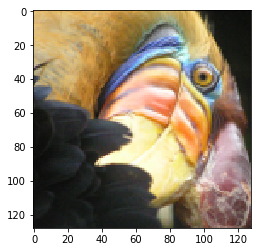

In [89]:
pic = 'data/bird_small.png'
pic = mpimg.imread(pic)
plt.imshow(pic)

In [90]:
A = pic_data['A']
print(A.shape)
A = np.reshape(A, (A.shape[0] * A.shape[1], A.shape[2]))
print(A.shape)

(128, 128, 3)
(16384, 3)


Let's combine K-Means and PCA to visualize our pixel assignments from 3D red, green, and blue space. Visualizing data in 3 dimensions is a lot of work and is acutally not very easy to understand relative to 2D plots. So we often like to draw in 2D even if we lose a little information via PCA. We can take a look at our compressed image data from K-Means projected down to 2D space.

In [91]:
initial_centroids = randomInitialization(A, 16)

history, indices = runKMeans(A, initial_centroids, 10)

In [92]:
A_mean, A_std, A_norm, A_U, A_S, A_V = doPca(A)

In [93]:
A_Z = projectData(A_norm, A_U, 2)

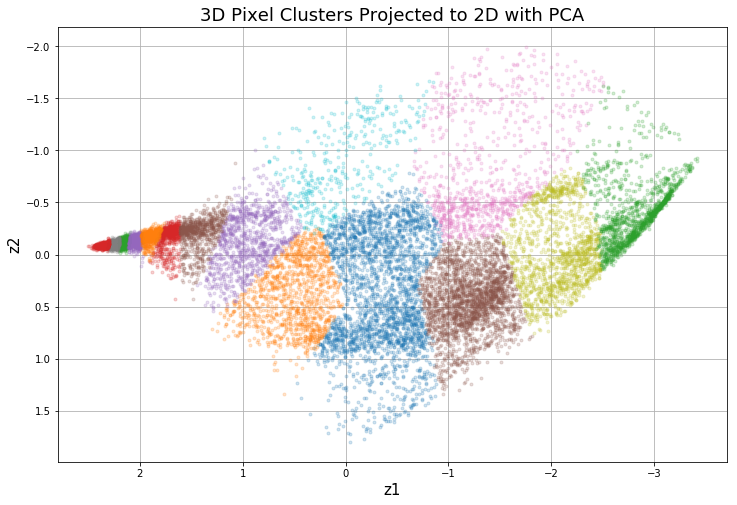

In [96]:
X_ = []
for i in np.arange(len(np.unique(indices))):
    X_.append(np.array([A_Z[j] for j in np.arange(A_Z.shape[0]) if indices[j] == i]))
        
fig = plt.figure(figsize=(12, 8))
for i in np.arange(len(X_)):
    newX = X_[i]
    plt.plot(newX[:, 0], newX[:, 1], '.', alpha = 0.2)

ax = plt.gca()
ax.invert_xaxis()
ax.invert_yaxis()
plt.xlabel('z1', fontsize = 15)
plt.ylabel('z2', fontsize = 15)
plt.title('3D Pixel Clusters Projected to 2D with PCA', fontsize = 18)
plt.grid(True)

How pretty! As Andrew Ng says, "The PCA projection can be thought of as a rotation that selects the view that maximizes the spread of the data, which often corresponds to the "best" view."

That's all for now on K-Means and PCA. I hope this was helpful to you, dear reader.